**Linear regression (a)**

In [92]:
# packages
import numpy as np
import pandas as pd
import sklearn.linear_model as lm
from sklearn import model_selection
import matplotlib.pyplot as plt
from toolbox_02450 import rlr_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

plt.style.use('fivethirtyeight')

In [113]:
# loading data
filename = 'data/glass.csv'
df = pd.read_csv(filename)

# defining x and y for the linear regression
#       all attributes except RI
X = np.array(df.iloc[:,2:10])
#       number of attributes
M = 8
#       RI
y = np.array(df.iloc[:,1])

#* ONE-HOT-ENCODING
#print(np.array(df.iloc[:,10]))
from sklearn.preprocessing import LabelEncoder
X_10 = LabelEncoder().fit_transform(np.array(df.iloc[:,10]))
# print(X_10.reshape(-1,1))
# print(OneHotEncoder().fit_transform(X = X_10.reshape(-1,1)))

C = 6
M = M + 6

one_hot = np.empty((len(X_10),C))
for j, i in enumerate(X_10):
    temp = np.zeros(6)
    temp[i] = 1
    one_hot[j,:] = temp

X = np.concatenate((X, one_hot), axis=1)

#* Off-set
X = np.concatenate((np.ones((X.shape[0],1)),X),1)
M = M+1


In [114]:
X.shape

(214, 14)

In [136]:
# K-fold with a reqularizatoin loop (using rlr_validate)
K = 5
CV = model_selection.KFold(n_splits=K,shuffle=True)

error_test = np.zeros(K)
error_train = np.zeros(K)

lambdas = np.power(10., np.linspace(-16,12,40))

w_rlr = np.empty((M,K))

#

for i, (train_index, test_index) in enumerate(CV.split(X)):
    X_train, X_test = X[train_index, :], X[test_index, :]
    y_train, y_test = y[train_index], y[test_index]

    # using the function from the toolbox (they do their own standardization)
    opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda = rlr_validate(X, y, lambdas, cvf = 10)

    # standardization (dont standardize offset)
    mu = np.mean(X_train[:, 1:],  axis = 0)
    sigma = np.std(X_train[:, 1:], axis = 0)
    
    X_train[:, 1:] = (X_train[:, 1:] - mu)/sigma
    X_test[:, 1:] = (X_test[: ,1:] - mu)/sigma

    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train

    lambdaI = opt_lambda * np.eye(M)

    w_rlr[:,i] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()

    error_train[i] = np.square(y_train-X_train @ w_rlr[:,i]).sum(axis=0)/y_train.shape[0]
    error_test[i] = np.square(y_test-X_test @ w_rlr[:,i]).sum(axis=0)/y_test.shape[0]





index:  20
lambda_star =  0.02285463864134993


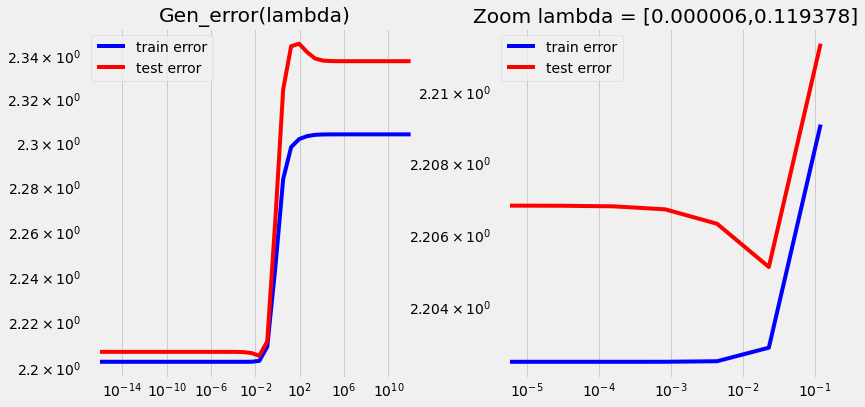

In [155]:
f, axs = plt.subplots(1, 2, figsize=(12,6))
axs[0].loglog(lambdas, train_err_vs_lambda.T, 'b-',label="train error")
axs[0].loglog(lambdas, test_err_vs_lambda.T, 'r-', label="test error")
axs[0].legend()
axs[0].set_title("Gen_error(lambda)")


# what is the mat-calculated min of the test error:
ind = np.argmin(test_err_vs_lambda)
print("index: ", ind)
print("lambda_star = ", lambdas[ind])

if lambdas[ind] != 1e-16:
    index_r = ind + 1
    index_l = ind - 5
    zoom = [i for i in range(index_l, index_r+1)]

    axs[1].loglog(lambdas[zoom], train_err_vs_lambda.T[zoom], 'b-',label="train error")
    axs[1].loglog(lambdas[zoom], test_err_vs_lambda.T[zoom], 'r-', label="test error")
    axs[1].set_title("Zoom lambda = [{:.6f},{:.6f}]".format(lambdas[index_l], lambdas[index_r]))
    axs[1].legend()

plt.show()

**Regression, part b**

Comparison of three models

In [156]:
# imports
import torch
import numpy as np
import pandas as pd
import sklearn.linear_model as lm
from sklearn import model_selection
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder


In [157]:
# loading data
filename = 'data/glass.csv'
df = pd.read_csv(filename)

# defining x and y for the linear regression
#       all attributes except RI
X = np.array(df.iloc[:,2:10])
#       number of attributes
M = 8
#       RI
y = np.array(df.iloc[:,1])

#* ONE-HOT-ENCODING
X_10 = LabelEncoder().fit_transform(np.array(df.iloc[:,10]))


C = 6
M = M + 6
one_hot = np.empty((len(X_10),C))
for j, i in enumerate(X_10):
    temp = np.zeros(6)
    temp[i] = 1
    one_hot[j,:] = temp

X = np.concatenate((X, one_hot), axis=1)
print(X.shape)

# lidt hurtigt lavet, så asserter lige
assert X.shape == (214,14)
assert C == 6 and M == 14

(214, 14)


In [ ]:
# TODO: Find out about Bias
# TODO: Base?
# TODO: ANN, i =1 ?
# TODO: is standardization only in relation to the mean and std of the TRAINING DATA?

# init for ANN
#n_hidden_units = 3
max_iter = 10000
tolerance = 1e-6
logging_frequency = 1000
best_final_loss = 1e100
n_replicates = 3



# model = lambda: torch.nn.Sequential(
#                     torch.nn.Linear(M, n_hidden_units), #M features to H hiden units
#                     # 1st transfer function, either Tanh or ReLU:
#                     #torch.nn.Tanh(),                            
#                     torch.nn.ReLU(),
#                     torch.nn.Linear(n_hidden_units, 1)) # H hidden units to 1 output neuron

loss_fn = torch.nn.MSELoss()


#K = K_outer = K_inner
K = 10

CV_outer = model_selection.KFold(n_splits=K,shuffle=True)

# lists we want to fill out every outer - loop - iteration :
h_i_list = np.zeros(K)
ANN_error_test = np.zeros(K)
ANN_error_train = np.zeros(K)
lambda_i = np.zeros(K)
Lin_error_test = np.zeros(K)
Lin_error_train = np.zeros(K)
Base_error_test = np.zeros(K)
Base_error_train = np.zeros(K)

lambdas = np.power(10., np.linspace(-16,9,40))
opt_lambda = np.zeros(K)
h = [i for i in range(1,11)]
opt_h = np.zeros(K)

##*OUTER LOOP*
for m, (train_index, test_index) in tqdm(enumerate(CV_outer.split(X))):
    X_train, X_test = X[train_index, :], X[test_index, :]
    y_train, y_test = y[train_index], y[test_index]

    # Standardization; ER DET KORREKT
    mean_ = np.mean(X_train)
    sigma_ = np.std(X_train)

    X_train = (X_train - mean_)/sigma_
    X_test = (X_test - mean_)/sigma_
    #y_train = (y_train - np.mean(y_train))/np.std(y_train)
    #y_test = (y_test - np.mean(y_test))/np.std(y_test)

    #init for optimal lambda
    w = np.empty((M,K,len(lambdas)))
    M = X_train.shape[1]
    train_error_lambda = np.empty((K,len(lambdas)))
    test_error_lambda = np.empty((K,len(lambdas)))
    j = 0
    
    #init for optimal h
    h_error_train = np.zeros(10)
    h_error_test = np.zeros(10)


    ##*INNER LOOP*
    CV_inner = model_selection.KFold(n_splits=K,shuffle=True)
    for j, (train_index_inner, test_index_inner) in enumerate(CV_inner.split(X_train, y_train)):
        # prinitng
        print("outer_loop: " + str(m+1) + "/10. inner_loop: " + str(j+1) + "/10.",end='\r')

        X_train_inner, X_test_inner = X_train[train_index_inner, :], X_train[test_index_inner, :]
        y_train_inner, y_test_inner = y_train[train_index_inner], y_train[test_index_inner]

        #standardization ?
        #mu[i,:] = np.mean(X_train, axis=0)
        #sigma[i,:] = np.std(X_train, axis=0)
        

        #finding optimal lambda
        # precompute terms
        # Xty = X_train_inner.T @ y_train_inner
        # XtX = X_train_inner.T @ X_train_inner
        # for l in range(0,len(lambdas)):
        #     # Compute parameters for current value of lambda and current CV fold
        #     # note: "linalg.lstsq(a,b)" is substitue for Matlab's left division operator "\"
        #     lambdaI = lambdas[l] * np.eye(M)
        #     #lambdaI[0,0] = 0 # remove bias regularization 
        #     w[:,j,l] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
        #     # Evaluate training and test performance
        #     train_error_lambda[j,l] = np.power(y_train_inner-X_train_inner @ w[:,j,l].T,2).mean(axis=0)
        #     test_error_lambda[j,l] = np.power(y_test_inner-X_test_inner @ w[:,j,l].T,2).mean(axis=0)




        #* Finding best hyperparameter lambda
        # precompute terms
        Xty = X_train_inner.T @ y_train_inner
        XtX = X_train_inner.T @ X_train_inner
        for l in range(0,len(lambdas)):
            # Compute parameters for current value of lambda and current CV fold
            # note: "linalg.lstsq(a,b)" is substitue for Matlab's left division operator "\"
            lambdaI = lambdas[l] * np.eye(M)
            lambdaI[0,0] = 0 # remove bias regularization
            w[:,f,l] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
            # Evaluate training and test performance
            train_error[f,l] = np.power(y_train-X_train @ w[:,f,l].T,2).mean(axis=0)
            test_error[f,l] = np.power(y_test-X_test @ w[:,f,l].T,2).mean(axis=0)
    
        f=f+1

        #opt_val_err = np.min(np.mean(test_error,axis=0))
        #opt_lambda = lambdas[np.argmin(np.mean(test_error,axis=0))]
        #train_err_vs_lambda = np.mean(train_error,axis=0)
        #test_err_vs_lambda = np.mean(test_error,axis=0)
        #mean_w_vs_lambda = np.squeeze(np.mean(w,axis=1))



        # finding best h
        X_train_inner, X_test_inner = torch.tensor(X_train_inner, dtype=torch.float), torch.tensor(X_test_inner, dtype=torch.float)
        y_train_inner, y_test_inner = torch.tensor(y_train_inner, dtype=torch.float), torch.tensor(y_test_inner, dtype=torch.float)
        y_test_inner = torch.reshape(y_test_inner, (y_test_inner.shape[0],1))
        y_train_inner = torch.reshape(y_train_inner, (y_train_inner.shape[0],1))

        n_hidden_units_inner = h[j]
        model_inner = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, n_hidden_units_inner), #M features to H hiden units
                    # 1st transfer function, either Tanh or ReLU:
                    #torch.nn.Tanh(),                            
                    torch.nn.ReLU(),
                    torch.nn.Linear(n_hidden_units_inner, 1)) # H hidden units to 1 output neuron

        oss_fn = torch.nn.MSELoss()

        for r in range(n_replicates):
            net_inner = model_inner()

            torch.nn.init.xavier_uniform_(net_inner[0].weight)
            torch.nn.init.xavier_uniform_(net_inner[2].weight)

            optimizer = torch.optim.Adam(net_inner.parameters())

            learning_curve = []
            old_loss = 1e6
            for i in range(max_iter):
                y_est = net_inner(X_train_inner)
                #y_class = torch.max(y_est, dim=1)[1]
                loss = loss_fn(y_est, y_train_inner)
                loss_value = loss.data.numpy()
                learning_curve.append(loss_value)


                p_delta_loss = np.abs(loss_value - old_loss)/old_loss
                if p_delta_loss < tolerance: break
                old_loss = loss_value


                #if (i != 0) & ((i+1) % logging_frequency == 0):
                #    print_str = '\t\t' + str(i+1) + '\t' + str(loss_value) + '\t' + str(p_delta_loss)
                #    print(print_str)
                optimizer.zero_grad(); loss.backward(); optimizer.step()

    

            if loss_value < best_final_loss:
                best_net = net_inner
                best_final_loss = loss_value
                best_learning_curve = learning_curve

        y_pred_inner = net_inner(X_test_inner)
        se_inner = (y_pred_inner.float() - y_test_inner.float())**2  # the squared error
        mse_inner = (sum(se_inner).type(torch.float)/len(y_test_inner)).data.numpy()
        h_error_test[j]  = mse_inner
        h_error_train[j] = best_final_loss # ikke helt korrekt men ved ikke om det er nødvændigt


    # opt_val_err = np.min(np.mean(test_error_lambda,axis=0))
    opt_lambda[m] = lambdas[np.argmin(np.mean(test_error_lambda,axis=0))]
    # train_err_vs_lambda = np.mean(train_error_lambda,axis=0)
    # test_err_vs_lambda = np.mean(test_error_lambda,axis=0)
    # mean_w_vs_lambda = np.squeeze(np.mean(w,axis=1))
    opt_h[m] = h[np.argmin(h_error_test)]


    ##*REGRESSION*
    # Baseline error-calculation
    Base_error_train[m] = np.square(y_train-y_train.mean()).sum(axis=0)/y_train.shape[0]
    Base_error_test[m] = np.square(y_test-y_test.mean()).sum(axis=0)/y_test.shape[0]

    # Linear regression
    lin = lm.Ridge(alpha=opt_lambda[m], fit_intercept=True).fit(X_train, y_train)

    # saving values
    Lin_error_train[m] = 1/X_train.shape[0] * np.sum(np.square(y_train - lin.predict(X_train)))
    Lin_error_test[m] = 1/X_test.shape[0] * np.sum(np.square(y_test - lin.predict(X_test)))

    #ANN
    X_train, X_test = torch.tensor(X_train, dtype = torch.float), torch.tensor(X_test, dtype=torch.float)
    y_train, y_test = torch.tensor(y_train, dtype = torch.float), torch.tensor(y_test, dtype=torch.float)
    y_test = torch.reshape(y_test, (y_test.shape[0],1))
    y_train = torch.reshape(y_train, (y_train.shape[0],1))

    

    model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, int(opt_h[m])), #M features to H hiden units
                    # 1st transfer function, either Tanh or ReLU:
                    #torch.nn.Tanh(),                            
                    torch.nn.ReLU(),
                    torch.nn.Linear(int(opt_h[m]), 1)) # H hidden units to 1 output neuron

    # Training  loop
    for r in range(n_replicates):
        net = model()

        torch.nn.init.xavier_uniform_(net[0].weight)
        torch.nn.init.xavier_uniform_(net[2].weight)

        optimizer = torch.optim.Adam(net.parameters())

        learning_curve = []
        old_loss = 1e6
        for i in range(max_iter):
            y_est = net(X_train)
            #y_class = torch.max(y_est, dim=1)[1]
            loss = loss_fn(y_est, y_train)
            loss_value = loss.data.numpy()
            learning_curve.append(loss_value)


            p_delta_loss = np.abs(loss_value - old_loss)/old_loss
            if p_delta_loss < tolerance: break
            old_loss = loss_value

            optimizer.zero_grad(); loss.backward(); optimizer.step()

        if loss_value < best_final_loss:
            best_net = net
            best_final_loss = loss_value
            best_learning_curve = learning_curve
        

        
    # save loss for ANN
    y_pred = net(X_test)
    se = (y_pred.float() - y_test.float())**2  # the squared error
    mse = (sum(se).type(torch.float)/len(y_test)).data.numpy()

    ANN_error_test[m] = np.mean(mse)
    ANN_error_train[m] = best_final_loss



    # lin = lm.Ridge(alpha=opt_lambda, fit_intercept=True).fit(X_train_inner, y_train_inner)

    # # saving values
    # Lin_error_train[m] = 1/X_train_inner.shape[0] * np.sum(np.square(y_train_inner - lin.predict(X_train_inner)))
    # Lin_error_test[m] = 1/X_test_inner.shape[0] * np.sum(np.square(y_test_inner - lin.predict(X_test_inner)))
 



In [202]:




#* INIT FOR ANN
max_iter = 10000
tolerance = 1e-6
#logging_frequency = 1000
best_final_loss = 1e100
n_replicates = 3
h_list = np.array([i*2+1 for i in range(5)])
ANN_error_test = np.zeros(K)
#ANN_error_train = np.zeros(K)
#loss_fn = torch.nn.MSELoss()
opt_h = np.zeros(K)


#* INIT FOR FINDING BEST LAMBDA
lambdas = lambdas = np.power(10., np.linspace(-16,12,10))
opt_lambda = np.zeros(K)

#* INIT FOR BASELINE
Base_error_train = np.zeros(K)
Base_error_test = np.zeros(K)

#* INIT FOR LINEAR REGRESSION
w_rlr = np.empty((M,K))
lin_error_train = np.zeros(K)
lin_error_test = np.zeros(K)


#* OUTER-LOOP
K = 10
CV_outer = model_selection.KFold(n_splits=K,shuffle=True)

for m, (train_index, test_index) in tqdm(enumerate(CV_outer.split(X))):
    X_train, X_test = X[train_index, :], X[test_index, :]
    y_train, y_test = y[train_index], y[test_index]


    # STANDARDIZATION
    mean_ = np.mean(X_train)
    sigma_ = np.std(X_train)
    X_train = (X_train - mean_)/sigma_
    X_test = (X_test - mean_)/sigma_


    # init for finding hyperparameter lambda
    train_error_lin_inner = np.zeros((K, len(lambdas)))
    test_error_lin_inner = np.zeros((K, len(lambdas)))
    w = np.empty((M,K,len(lambdas)))
    M = X_train.shape[1]

    # init for finding best h
    h_error_test = np.zeros((K, len(h_list)))


    #* INNER LOOP
    CV_inner = model_selection.KFold(n_splits=K,shuffle=True)
    for j, (train_index_inner, test_index_inner) in enumerate(CV_inner.split(X_train, y_train)):
        # prinitng
        print("outer_loop: " + str(m+1) + "/10. inner_loop: " + str(j+1) + "/10.",end='\r')

        X_train_inner, X_test_inner = X_train[train_index_inner, :], X_train[test_index_inner, :]
        y_train_inner, y_test_inner = y_train[train_index_inner], y_train[test_index_inner]


        #* Finding best hyperparameter lambda
        # precompute terms
        Xty = X_train.T @ y_train
        XtX = X_train.T @ X_train

        for l in range(0,len(lambdas)):

            lambdaI = lambdas[l] * np.eye(M)
            lambdaI[0,0] = 0 # remove bias regularization
            w[:,j,l] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
            # Evaluate training and test performance

            train_error_lin_inner[j,l] = np.power(y_train-X_train @ w[:,j,l].T,2).mean(axis=0)
            test_error_lin_inner[j,l] = np.power(y_test-X_test @ w[:,j,l].T,2).mean(axis=0)

        #* Finding the best hyperparameter h
        X_train_inner, X_test_inner = torch.tensor(X_train_inner, dtype=torch.float), torch.tensor(X_test_inner, dtype=torch.float)
        y_train_inner, y_test_inner = torch.tensor(y_train_inner, dtype=torch.float), torch.tensor(y_test_inner, dtype=torch.float)

        y_train_inner = y_train_inner.reshape((len(y_train_inner),1))
        y_test_inner = y_test_inner.reshape((len(y_test_inner),1))

        for p, hidden_value_ in enumerate(h_list):
            # define the model for each hidden layer
            model_inner = lambda: torch.nn.Sequential(
                        torch.nn.Linear(M, hidden_value_), #M features to H hiden units
                        # 1st transfer function, either Tanh or ReLU:
                        #torch.nn.Tanh(),                            
                        torch.nn.ReLU(),
                        torch.nn.Linear(hidden_value_, 1))

            # loss function for regression
            loss_fn = torch.nn.MSELoss()


            # Training the model
            for r in range(n_replicates):
                net_inner = model_inner()

                torch.nn.init.xavier_uniform_(net_inner[0].weight)
                torch.nn.init.xavier_uniform_(net_inner[2].weight)

                optimizer = torch.optim.Adam(net_inner.parameters())

                learning_curve = []
                old_loss = 1e6
                for i in range(max_iter):
                    y_est = net_inner(X_train_inner)
                    #y_class = torch.max(y_est, dim=1)[1]
                    loss = loss_fn(y_est, y_train_inner)
                    loss_value = loss.data.numpy()
                    learning_curve.append(loss_value)

                    p_delta_loss = np.abs(loss_value - old_loss)/old_loss
                    if p_delta_loss < tolerance: break
                    old_loss = loss_value

                    optimizer.zero_grad(); loss.backward(); optimizer.step()

            # saving the mean-squared-error
            y_test_inner_est = net_inner(X_test_inner)
            se = (y_test_inner_est.float() - y_test_inner.float())**2  # the squared error
            mse = (sum(se).type(torch.float)/len(y_test_inner)).data.numpy()
            h_error_test[j, p]  = mse

    #* CALCULATING BEST HYPERPARARMETERS

    opt_lambda[m] = lambdas[np.argmin(np.mean(test_error_lin_inner,axis=0))]
    opt_h[m] = h_list[np.argmin(np.mean(h_error_test, axis = 0))]



    #* REGRESSION

    ###############################
    #*       BASELINE
    Base_error_train[m] = np.square(y_train-y_train.mean()).sum(axis=0)/y_train.shape[0]
    Base_error_test[m] = np.square(y_test-y_test.mean()).sum(axis=0)/y_test.shape[0]


    ###############################
    #*      Linear regression
    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train

    lambdaI = opt_lambda[m] * np.eye(M)

    w_rlr[:,m] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()

    lin_error_train[m] = np.square(y_train-X_train @ w_rlr[:,m]).sum(axis=0)/y_train.shape[0]
    lin_error_test[m] = np.square(y_test-X_test @ w_rlr[:,m]).sum(axis=0)/y_test.shape[0]

    ##############################
    #*       ANN - Regression

    model = lambda: torch.nn.Sequential(
                        torch.nn.Linear(M, hidden_value_), #M features to H hiden units
                        # 1st transfer function, either Tanh or ReLU:
                        #torch.nn.Tanh(),                            
                        torch.nn.ReLU(),
                        torch.nn.Linear(hidden_value_, 1))

    # loss function for regression
    loss_fn = torch.nn.MSELoss()

    X_train, y_train = torch.tensor(X_train, dtype = torch.float), torch.tensor(y_train, dtype = torch.float)
    X_test, y_test = torch.tensor(X_test, dtype = torch.float), torch.tensor(y_test , dtype = torch.float)

    y_train = y_train.reshape((len(y_train),1))
    y_test= y_test.reshape((len(y_test),1))


    # Training the model
    for r in range(n_replicates):
        net = model()

        torch.nn.init.xavier_uniform_(net[0].weight)
        torch.nn.init.xavier_uniform_(net[2].weight)

        optimizer = torch.optim.Adam(net.parameters())

        learning_curve = []
        old_loss = 1e6
        for i in range(max_iter):
            y_est = net(X_train)
            #y_class = torch.max(y_est, dim=1)[1]
            loss = loss_fn(y_est, y_train)
            loss_value = loss.data.numpy()
            learning_curve.append(loss_value)

            p_delta_loss = np.abs(loss_value - old_loss)/old_loss
            if p_delta_loss < tolerance: break
            old_loss = loss_value

            optimizer.zero_grad(); loss.backward(); optimizer.step()

    y_test_est = net(X_test)
    se = (y_test_est.float() - y_test.float())**2  # the squared error
    mse = (sum(se).type(torch.float)/len(y_test)).data.numpy()

    ANN_error_test[m] = mse



    


0it [00:00, ?it/s]

1it [07:35, 455.99s/it]

2it [14:07, 417.78s/it]

3it [20:51, 411.79s/it]

4it [27:40, 410.70s/it]

5it [35:11, 425.17s/it]

5it [40:36, 487.38s/it]


KeyboardInterrupt: 

In [203]:




print("{:<15} | {:<15} {:<15} {:<15} {:<15} {:<15}".format('Outer fold i', 'h', 'E_ANN', 'lambda', 'E_lin', 'E_base'))
print("-----------------------------------------------------------------------------------------")
for i in range(10):
    print("{:<15} | {:<15} {:<15.7f} {:<15.7f} {:<15.7f} {:<15.7f}".format(i+1, int(opt_h[i]), ANN_error_test[i], opt_lambda[i], lin_error_test[i], Base_error_test[i]))


Outer fold i    | h               E_ANN           lambda          E_lin           E_base         
-----------------------------------------------------------------------------------------
1               | 1               0.0000088       0.0000000       0.0000015       0.0000093      
2               | 1               0.0000047       0.0000002       0.0000019       0.0000066      
3               | 5               0.0000079       0.0000000       0.0000009       0.0000059      
4               | 1               0.0005294       0.0000002       0.0000028       0.0000145      
5               | 1               0.0000059       0.0000002       0.0000002       0.0000084      
6               | 0               0.0000000       0.0000000       0.0000000       0.0000000      
7               | 0               0.0000000       0.0000000       0.0000000       0.0000000      
8               | 0               0.0000000       0.0000000       0.0000000       0.0000000      
9               | 0         

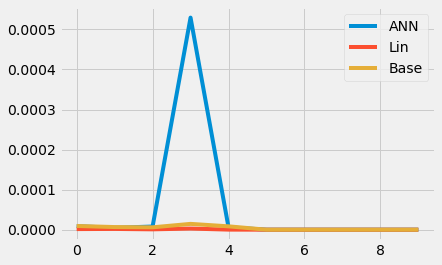

In [212]:
plt.plot(ANN_error_test)
plt.plot(lin_error_test)
plt.plot(Base_error_test)
#plt.axhline(0.5,color='red')
plt.legend(['ANN', 'Lin', 'Base'])
plt.show()

In [210]:
Base_error_test

array([9.31454814e-06, 6.58289938e-06, 5.92336963e-06, 1.45197240e-05,
       8.39264671e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

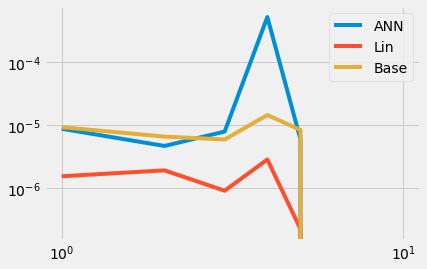

In [214]:
plt.loglog([i+1 for i in range(10)], ANN_error_test)
plt.loglog([i+1 for i in range(10)],lin_error_test)
plt.loglog([i+1 for i in range(10)],Base_error_test)
#plt.axhline(0.5,color='red')
plt.legend(['ANN', 'Lin', 'Base'])

In [2]:
import pandas as pd
import numpy as np

table = np.array([opt_h, ANN_error_test, opt_lambda, lin_error_test, Base_error_test])

df = pd.DataFrame(np.transpose(table))

df.to_csv('regression_results.csv', index = False, header = ["test_size", "h", "ANN", "lambda", "Log", "Base"])



NameError: name 'opt_h' is not defined